# import

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)

In [2]:
con_08 = pd.read_csv('../data/데이터스쿨3차_2308월/데이터스쿨_3차_콘텐츠_2308.csv', encoding = 'cp949', sep = '\t')
con_09 = pd.read_csv('../data/데이터스쿨3차_2309월/데이터스쿨_3차_콘텐츠_2309.csv', encoding = 'cp949', sep = '\t')
vod_id = pd.read_csv('../data/전처리data/vod_id_origin.csv', encoding = 'cp949')

In [3]:
# 8,9월 데이터 합치기
con_89 = pd.concat([con_08, con_09], ignore_index=True)
con_89.head(3)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt
0,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071155
1,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071215
2,66056000,라바 키즈동요(한국어) Part4,라바 키즈동요(한국어) Part4 17회,키즈,기타,징글벨 크리스마스. 안녕하신가 친구들! 메리 크리스마스~ 징글벨 크리스마스 징글벨 ...,"엘로우,레드",0:02,20230808085440


# 전처리

In [5]:
from pandas._libs.tslibs.offsets import Hour
def preprocessing(data):
  df = data.copy()
  # 특수 문자 정리
  ## 예고편 제거
  df = df[~df['super_asset_nm'].str.contains(r'\(예고편\)|\(예고\)', regex=True)]
  
  # series_nm 괄호와 그 안의 내용 제거
  df['series_nm'] = df['series_nm'].str.replace(r'\([^()]*\)', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\[[^\[\]]*\]', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\.\.\.', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'…', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace('-', ' ')
  df['series_nm'] = df['series_nm'].str.rstrip('.')

  # super_asset_nm 변경
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\([^()]*\)', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\[[^\[\]]*\]', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\.\.\.', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'…', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace('-', ' ')
  df['super_asset_nm'] = df['super_asset_nm'].str.rstrip('.')

  # 'series_nm'이 null인 경우, 'super_asset_nm'의 값으로 대체
  df['series_nm'].fillna(df['super_asset_nm'], inplace=True)

  # 회, 회., 화, 실사판, 무삭제 제거
  df['series_nm'] = df['series_nm'].str.replace(r'무삭제판|무삭제', '', regex = True)
  df['series_nm'] = df['series_nm'].str.replace(r'실사판', '', regex = True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+회$', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+회\.', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+화$', '', regex = True)
  df['series_nm'] = df['series_nm'].str.strip()
  df['series_nm'] = df['series_nm'].str.rstrip('.')

  # 무삭제 제거
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'무삭제판|무삭제', '', regex = True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'실사판', '', regex = True)
  df['super_asset_nm'] = df['super_asset_nm'].str.strip()
  df['super_asset_nm'] = df['super_asset_nm'].str.rstrip('.')

  # disp_rtm 문자열을 분 단위로 변경
  def convert_runtime(runtime_str):
    # 입력값이 NaN이면 0 반환
    if pd.isna(runtime_str):
        return 0

    hours = int(runtime_str.split(':')[0])
    minutes = int(runtime_str.split(':')[1])
    total_minutes = hours * 60 + minutes
    return total_minutes

  df['disp_rtm'] = df['disp_rtm'].apply(convert_runtime)

  # 런타임 0분인 것 제거
  # df = df[df['disp_rtm'] != 0]

  # 예고편 제거
  # df = df[~df['series_nm'].str.contains(r'\(예고편\)|\(예고\)', regex=True)]

  # # 예약구매, 사전구매 제거
  # df = df[~df['series_nm'].str.contains('예약구매|사전구매')]

  # 00회가 포함된 행은 런타임이 0또는 1이므로 제거
  df = df[~df['series_nm'].str.contains(r'\b00회\b')]

  # 셋탑번호가 66056000인 것 삭제 - content 에서 이상치 아이디로 판별
  df = df[df['subsr'] != 66056000]

  df['category'] = df['ct_cl'].apply(lambda x : x if x in ['영화', '키즈'] else 'TV프로그램')
  df['rename'] = df['series_nm'].apply(lambda x : x.replace(' ', '') if isinstance(x, str) else x)

  return df

In [6]:
df = preprocessing(con_89)
df.head(1)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요


In [7]:
# id 병합
id = vod_id[['rename', 'Category', 'vod_id']]
id.columns = ['rename', 'category', 'vod_id']
id

,rename,category,vod_id
0,와이낫크루뜻밖의여행,TV프로그램,0
1,그레이트뷰티,영화,1
2,해안선,영화,2
3,아는형님,TV프로그램,3
4,베놈,영화,4
...,...,...,...
4710,베놈2:렛데어비카니지,영화,4710
4711,성월동화,영화,4711
4712,다큐인사이트코드블루,TV프로그램,4712
4713,캠프제로베이스원,TV프로그램,4713


In [9]:
df1 = df.merge(id, on = ['rename', 'category'], how = 'left')
df1

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요,882
1,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071215,키즈,핑크퐁동물동요,882
2,63086000,지니강이 플러스 시즌7,지니강이 플러스 시즌7. 26회,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,20230827145542,키즈,지니강이플러스시즌7,1622
3,63086000,지니강이 플러스 시즌9,지니강이 플러스 시즌9. 26회,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,20230827152417,키즈,지니강이플러스시즌9,2043
4,62733000,엘리가간다 시즌12,엘리가간다 시즌12 25회,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,20230816112816,키즈,엘리가간다시즌12,1958
...,...,...,...,...,...,...,...,...,...,...,...,...
21124,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121656,키즈,슈퍼토끼,544
21125,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121646,키즈,슈퍼토끼,544
21126,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544
21127,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544


In [10]:
df1[df1['vod_id'].isna()]

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id


In [11]:
# watched : 유저 - 프로그램당 개수
df2 =  df1.groupby(['subsr', 'vod_id']).size().reset_index(name='watched').sort_values(by='watched', ascending=False)
df2

,subsr,vod_id,watched
3470,64154000,754,232
399,60326000,908,119
4309,64720000,336,110
4281,64680000,1166,105
3678,64385000,16,104
...,...,...,...
4406,64776000,3803,1
4408,64776000,4109,1
4409,64776000,4673,1
4410,64776000,4678,1


In [70]:
# series_nm과 super_asset_nm에서 회차 제거
df33 = df1.copy()

df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'무삭제판|무삭제', '', regex = True)
df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'실사판', '', regex = True)
df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\d+회$', '', regex=True)
df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\d+회\.', '', regex=True)
df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\d+화$', '', regex = True)
df['super_asset_nm'] = df['super_asset_nm'].str.strip()
df['super_asset_nm'] = df['super_asset_nm'].str.rstrip('.')

df33

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요,882
1,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071215,키즈,핑크퐁동물동요,882
2,63086000,지니강이 플러스 시즌7,지니강이 플러스 시즌7. 26회,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,20230827145542,키즈,지니강이플러스시즌7,1622
3,63086000,지니강이 플러스 시즌9,지니강이 플러스 시즌9. 26회,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,20230827152417,키즈,지니강이플러스시즌9,2043
4,62733000,엘리가간다 시즌12,엘리가간다 시즌12 25회,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,20230816112816,키즈,엘리가간다시즌12,1958
...,...,...,...,...,...,...,...,...,...,...,...,...
21124,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121656,키즈,슈퍼토끼,544
21125,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121646,키즈,슈퍼토끼,544
21126,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544
21127,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544


In [41]:
filtered_rows = df4[df4.duplicated(subset=['vod_id'])]
filtered_rows

,series_nm,vod_id,watched_all
725,라이온 킹,3112,8
1077,범죄도시 2,723,4
228,공조 2: 인터내셔날,6,3
2125,존 윅 4,652,2
2067,전설의고향,4444,1
1459,스파이더맨: 노 웨이 홈 펀버전,661,1
1048,백 스테이지,437,1


In [62]:
# watched_all 생성 (프로그램(회차 x) 당 총 클릭 횟수)
df4 = df33.groupby(['vod_id']).size().reset_index(name='watched_all').sort_values(by='watched_all', ascending=False)
df4

,vod_id,watched_all
1515,2537,526
733,1166,394
174,296,374
1373,2288,303
6,8,291
...,...,...
1630,2741,1
589,919,1
1625,2732,1
1624,2729,1


In [63]:
df5 = df33.groupby(['subsr']).size().reset_index(name='watched_cnt').sort_values(by='watched_cnt', ascending=False)
df5

,subsr,watched_cnt
347,64154000,853
376,64385000,837
97,60939000,759
50,60326000,759
67,60593000,632
...,...,...
451,64937000,1
670,66182000,1
123,61223000,1
663,66144000,1


# 병합

In [64]:
# user-program 당 개수
df2.head()

,subsr,vod_id,watched
3470,64154000,754,232
399,60326000,908,119
4309,64720000,336,110
4281,64680000,1166,105
3678,64385000,16,104


In [73]:
df33 = df33[['subsr', 'series_nm', 'super_asset_nm', 'disp_rtm', 'category', 'rename', 'vod_id']]
df33.head(1)

,subsr,series_nm,super_asset_nm,disp_rtm,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,1,키즈,핑크퐁동물동요,882


In [78]:
# 병합할 데이터
df3 = df33[['subsr', 'series_nm', 'rename', 'super_asset_nm', 'vod_id', 'category']].drop_duplicates().reset_index(drop = True)
df3.head()

,subsr,series_nm,rename,super_asset_nm,vod_id,category
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요 20회,882,키즈
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7. 26회,1622,키즈
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9. 26회,2043,키즈
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12 25회,1958,키즈
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8. 26회,1596,키즈


In [80]:
# watched 병합
df6 = df3.merge(df2, on = ['subsr', 'vod_id'], how='left')
df6

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요 20회,882,키즈,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7. 26회,1622,키즈,2
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9. 26회,2043,키즈,1
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12 25회,1958,키즈,1
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8. 26회,1596,키즈,2
...,...,...,...,...,...,...,...
10391,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3 36회,3135,키즈,1
10392,63086000,크니쁘니히어로즈,크니쁘니히어로즈,크니쁘니히어로즈 4회,1292,키즈,11
10393,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕 29회,10,키즈,1
10394,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1 52회,3468,키즈,1


In [81]:
df6[df6['watched'].isna()]

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched


In [83]:
# 프로그램 총 몇번 시청 되었는지 확인
df4

,vod_id,watched_all
1515,2537,526
733,1166,394
174,296,374
1373,2288,303
6,8,291
...,...,...
1630,2741,1
589,919,1
1625,2732,1
1624,2729,1


In [85]:
# watched_all 병합
df7 = df6.merge(df4, on = ['vod_id'], how='left')
df7

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched,watched_all
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요 20회,882,키즈,2,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7. 26회,1622,키즈,2,2
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9. 26회,2043,키즈,1,1
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12 25회,1958,키즈,1,2
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8. 26회,1596,키즈,2,2
...,...,...,...,...,...,...,...,...
10391,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3 36회,3135,키즈,1,1
10392,63086000,크니쁘니히어로즈,크니쁘니히어로즈,크니쁘니히어로즈 4회,1292,키즈,11,11
10393,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕 29회,10,키즈,1,1
10394,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1 52회,3468,키즈,1,1


In [86]:
df7[df7['watched_all'].isna()]

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched,watched_all


In [87]:
# 유저가 프로그램 총 본 횟수
df5.head(5)

,subsr,watched_cnt
347,64154000,853
376,64385000,837
97,60939000,759
50,60326000,759
67,60593000,632


In [89]:
# watched_all 병합
df8 = df7.merge(df5, on = ['subsr'], how='left')
df8

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched,watched_all,watched_cnt
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요 20회,882,키즈,2,2,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7. 26회,1622,키즈,2,2,164
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9. 26회,2043,키즈,1,1,164
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12 25회,1958,키즈,1,2,2
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8. 26회,1596,키즈,2,2,164
...,...,...,...,...,...,...,...,...,...
10391,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3 36회,3135,키즈,1,1,22
10392,63086000,크니쁘니히어로즈,크니쁘니히어로즈,크니쁘니히어로즈 4회,1292,키즈,11,11,164
10393,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕 29회,10,키즈,1,1,2
10394,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1 52회,3468,키즈,1,1,164


In [90]:
df8[df8['watched_cnt'].isna()]

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched,watched_all,watched_cnt


In [92]:
import numpy as np
def scoring(df):
  N = df['watched_all']
  L = df['watched_cnt']
  n = df['watched']
  lam = np.log(2) / 2
  w1 = 1 - np.exp(-1 * lam * N)
  data = pd.DataFrame([N, L]).T
  def custom_weight(data):
    if data['watched_cnt'] < data['watched_all']:
      return data['watched_all'] / data['watched_cnt']
    else:
      return 1

  w2 = data.apply(custom_weight, axis = 1)

  score = (n / N) * w1 * w2

  return score

In [115]:
df8['cpaper_score'] = scoring(df8)
df8

,subsr,series_nm,rename,super_asset_nm,vod_id,category,watched,watched_all,watched_cnt,cpaper_score
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요 20회,882,키즈,2,2,2,0.500000
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7. 26회,1622,키즈,2,2,164,0.500000
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9. 26회,2043,키즈,1,1,164,0.292893
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12 25회,1958,키즈,1,2,2,0.250000
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8. 26회,1596,키즈,2,2,164,0.500000
...,...,...,...,...,...,...,...,...,...,...
10391,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3 36회,3135,키즈,1,1,22,0.292893
10392,63086000,크니쁘니히어로즈,크니쁘니히어로즈,크니쁘니히어로즈 4회,1292,키즈,11,11,164,0.977903
10393,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕 29회,10,키즈,1,1,2,0.292893
10394,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1 52회,3468,키즈,1,1,164,0.292893


In [120]:
content_paper_score = df8[['subsr', 'rename', 'series_nm', 'vod_id', 'cpaper_score', 'category']]
content_paper_score = content_paper_score.drop_duplicates(subset=['subsr', 'vod_id'])
content_paper_score

,subsr,rename,series_nm,vod_id,cpaper_score,category
0,65968000,핑크퐁동물동요,핑크퐁 동물 동요,882,0.500000,키즈
1,63086000,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,0.500000,키즈
2,63086000,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,0.292893,키즈
3,62733000,엘리가간다시즌12,엘리가간다 시즌12,1958,0.250000,키즈
4,63086000,지니강이플러스시즌8,지니강이 플러스 시즌8,1596,0.500000,키즈
...,...,...,...,...,...,...
10390,64982000,포켓몬스터XYandZ,포켓몬스터 XY and Z,2918,0.292893,키즈
10391,66864000,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3,3135,0.292893,키즈
10393,59917000,라바인뉴욕,라바 인 뉴욕,10,0.292893,키즈
10394,63086000,사이틴시즌1,사이틴 시즌1,3468,0.292893,키즈


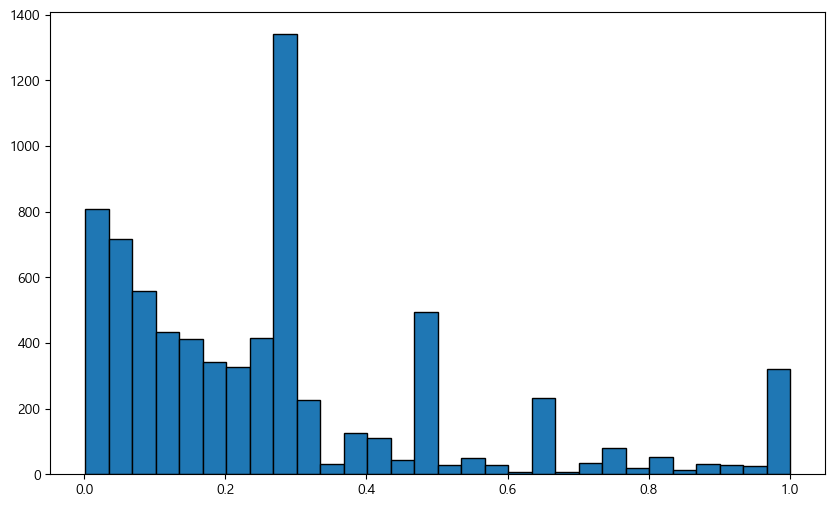

In [123]:
# plotting 환경 설정
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(content_paper_score['cpaper_score'], bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.show()

In [128]:
content_paper_score.to_csv('../data/전처리data/content_paper_score.csv',encoding='cp949', index = 0)

# paper_plus 생성

In [125]:
plus = pd.read_csv('../data/전처리data/content_plus.csv', encoding='cp949')
plus.rename(columns={'score':'cpaper_score'}, inplace=True)
plus.head(1)

,subsr,series_nm,vod_id,ct_cl,genre_of_ct_cl,category,cpaper_score
0,66424000,나 혼자산다,432,TV 연예/오락,기타,TV프로그램,1


In [126]:
paper_plus = pd.concat([content_paper_score, plus], axis=0, join='outer').fillna({'cpaper_score': 1}).reset_index(drop=True)
paper_plus = paper_plus.sort_values(by = 'subsr').reset_index(drop = True)
paper_plus

,subsr,rename,series_nm,vod_id,cpaper_score,category,ct_cl,genre_of_ct_cl
0,59879000,나쁜엄마,나쁜엄마,3403,0.187500,TV프로그램,NaN,NaN
1,59879000,쌍갑포차,쌍갑포차,3115,0.292893,TV프로그램,NaN,NaN
2,59879000,나의해방일지,나의 해방일지,1859,0.292893,TV프로그램,NaN,NaN
3,59879000,슬기로운의사생활시즌2,슬기로운 의사생활 시즌2,2891,0.292893,TV프로그램,NaN,NaN
4,59879000,낭만닥터김사부2,낭만닥터 김사부2,1168,0.106201,TV프로그램,NaN,NaN
...,...,...,...,...,...,...,...,...
7539,67160000,콘크리트유토피아,콘크리트 유토피아,2630,0.125000,영화,NaN,NaN
7540,67160000,더문,더 문,2866,0.125000,영화,NaN,NaN
7541,67161000,스파이코드명포춘,스파이 코드명 포춘,3824,0.999989,영화,NaN,NaN
7542,67164000,미션임파서블:데드레코닝PARTONE,미션 임파서블: 데드 레코닝 PART ONE,2867,0.249023,영화,NaN,NaN


In [127]:
paper_plus[paper_plus['cpaper_score'].isna()]

,subsr,rename,series_nm,vod_id,cpaper_score,category,ct_cl,genre_of_ct_cl


In [129]:
paper_plus.to_csv('../data/전처리data/paper_plus.csv',encoding='cp949', index = 0)